In [182]:
from pytorch_lightning.utilities.seed import seed_everything
RANDOM_SEED = 42
seed_everything(seed=RANDOM_SEED)

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Created a temporary directory at /tmp/tmp37bwfany
INFO: Writing /tmp/tmp37bwfany/_remote_module_non_scriptable.py
INFO: Global seed set to 42


42

# Data loading

In [123]:
import mirdata
from mir_eval.util import merge_labeled_intervals, adjust_intervals

billboard = mirdata.initialize('billboard')
billboard.download()
billboard.load_tracks()

dataset = list()

for i, track in tracks.items():
  try:
    section_intervals = track.named_sections.intervals
    sections = track.named_sections.labels

    # adjust chord intervals to match
    chord_intervals, chords = adjust_intervals(track.chords_full.intervals, 
                                              labels=track.chords_full.labels, 
                                              t_min=section_intervals.min(), 
                                              t_max=section_intervals.max(), 
                                              start_label="N", 
                                              end_label="N")

    _, sections, chords = merge_labeled_intervals(section_intervals, sections, chord_intervals, chords)
    dataset.append((chords, sections))
  except Exception as e:
    print("Track", i, "not parsable")

INFO: Downloading ['metadata', 'annotation_salami', 'annotation_lab', 'annotation_mirex13', 'annotation_chordino'] to /home/n28div/mir_datasets/billboard
INFO: [metadata] downloading billboard-2.0-index.csv
INFO: /home/n28div/mir_datasets/billboard/billboard-2.0-index.csv already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: [annotation_salami] downloading billboard-2.0-salami_chords.tar.gz
INFO: /home/n28div/mir_datasets/billboard/billboard-2.0-salami_chords.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: [annotation_lab] downloading billboard-2.0.1-lab.tar.gz
INFO: /home/n28div/mir_datasets/billboard/billboard-2.0.1-lab.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: [annotation_mirex13] downloading billboard-2.0.1-mirex.tar.gz
INFO: /home/n28div/mi

Track 974 not parsable


In [124]:
from itertools import chain

sections = list(chain(*[s for _, s in dataset]))
print(f"Total of {len(sections)} annotations - {len(set(sections))} unique")

Total of 148394 annotations - 80 unique


Unify most sections as possible.

In [173]:
import re
import functools
import string

SYMBOLS_RE = re.compile("[" + re.escape(string.punctuation) + "]")
NUMBERS_RE = re.compile("[" + re.escape(string.digits) + "]")
CONSECUTIVE_SPACES_RE = re.compile(r"\s+")

VERSE_RE = re.compile(r"(verse)")
PRECHORUS_RE = re.compile(r"(prechorus|pre chorus)")
CHORUS_RE = re.compile(r"(chorus)")
INTRO_RE = re.compile(r"(fadein|fade in|intro)")
OUTRO_RE = re.compile(r"(outro|coda|fadeout|fade-out|ending)")
INSTRUMENTAL_RE = re.compile(r"""(applause|bass|choir|clarinet|drums|flute|harmonica|harpsichord|
                                  instrumental|instrumental break|noise|oboe|organ|piano|rap|
                                  saxophone|solo|spoken|strings|synth|synthesizer|talking|
                                  trumpet|vocal|voice|guitar|saxophone|trumpet)""")
THEME_RE = re.compile(r"(main theme|theme|secondary theme)")
TRANSITION_RE = re.compile(r"(transition|trans)")
OTHER_RE = re.compile(r"(modulation|key change)")

def preprocess_section(section):
  # remove symbols, numbers and spaces
  section = SYMBOLS_RE.sub(" ", section)
  section = NUMBERS_RE.sub(" ", section)
  section = CONSECUTIVE_SPACES_RE.sub(" ", section)
  
  section = "verse" if VERSE_RE.search(section) else section
  section = "prechorus" if PRECHORUS_RE.search(section) else section
  section = "chorus" if CHORUS_RE.search(section) else section
  section = "intro" if INTRO_RE.search(section) else section
  section = "outro" if OUTRO_RE.search(section) else section
  section = "instrumental" if INSTRUMENTAL_RE.search(section) else section
  section = "theme" if THEME_RE.search(section) else section
  section = "transition" if TRANSITION_RE.search(section) else section
  section = "other" if OTHER_RE.search(section) else section
  
  section = section.strip()
  return section

In [178]:
sorted(Counter([preprocess_section(s) for s in sections]).items(), key=lambda i: i[1], reverse=True)

[('verse', 50310),
 ('chorus', 46495),
 ('instrumental', 13878),
 ('outro', 11852),
 ('intro', 10273),
 ('bridge', 7029),
 ('interlude', 5038),
 ('transition', 2773),
 ('theme', 446),
 ('refrain', 247),
 ('other', 53)]

In [179]:
dataset = [
  (chords, [preprocess_section(s) for s in sections])
  for chords, sections in dataset
]

## Visualize section annotations

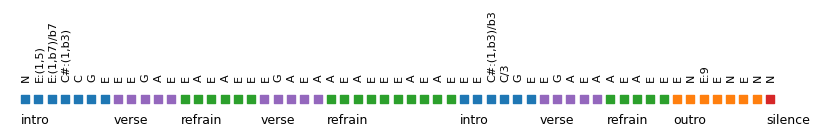

In [234]:
import matplotlib.pyplot as plt
from more_itertools import windowed
import numpy as np

def plot_segmentation(seq, y_base=1, title="", show_content=False, ax=None):
  if ax is None:
    _, ax = plt.subplots()
  
  sections, seg = np.unique([ann.section for ann in seq.annotations], return_inverse=True)
  positions = [(label, np.where(seg == label)[0]) for label in np.unique(seg)]
  
  colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0, 1, len(positions))]
  markers = [marker for _, marker in plt.Line2D.markers.items() if marker != "nothing"]
  for idx, (lbl, idxs) in enumerate(positions):           
    ax.scatter(idxs, np.full_like(idxs, y_base), marker="s", s=40, label=sections[idx])
    
    text_points = [g[0] for g in np.split(idxs, np.where(np.diff(idxs) != 1)[0]+1)]
    for i in text_points:
      ax.text(i - 0.3, y_base - 1.3, sections[idx], size=9, family="Libertinus")

    for i in idxs:
      ax.text(i - 0.3, y_base + 1, seq.annotations[i].chord.symbol, rotation=90, size=8)
  
  #ax.legend(loc="upper left", ncol=len(sections))
  ax.axis("off")
  ax.set_ylim(0, 4)
  ax.set_title(title)
  ax.margins(0.02)

fig, ax = plt.subplots(figsize=(10, 1))
helter = next(filter(lambda doc: doc.jams.file_metadata.title == "Helter Skelter", simplified_dataset))
plot_segmentation(helter, show_content=False, ax=ax)
fig.savefig("helterskelter.png")

# Data preparation

In [188]:
from sklearn.model_selection import train_test_split

X, y = zip(*dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED)

Pad all the sequences to the longest sequence in the split and encode them using the embedding.

In [190]:
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import OneHotEncoder
import numpy as np

labels = list(set.union(*[set(yi) for yi in y_train]))
encoder = OneHotEncoder().fit(np.array(labels).reshape(-1, 1))

def embed_data(model, X, y, encoder):
    seq_length = [len(xi) for xi in X]
    max_seq_length = max(seq_length)
    
    padded_seq = np.stack(
        [np.pad(xi, (0, max_seq_length - len(xi)), constant_values="P") 
         for xi in X])
    
    padding_mask = torch.tensor((padded_seq == "P").astype(int))
    padded_seq[padding_mask == 1] = "N"
    
    embedded_seq = torch.tensor(np.stack([[model[sample]
                                         for sample in seq] 
                                        for seq in padded_seq]))
    
    
    encoded_labels = [torch.tensor(encoder.transform(yi.reshape(-1, 1)).todense()) for yi in y]
    padded_labels = pad_sequence(encoded_labels, batch_first=True, padding_value=0)
  
    return embedded_seq, padded_labels, padding_mask

# FORM Baseline

In [191]:
from segmentation.form import FORM
from mir_eval.util import boundaries_to_intervals
from mir_eval.segment import pairwise, nce
import numpy as np

In [192]:
metrics = list()

for xi, yi in zip(X_test, y_test):
    intervals = boundaries_to_intervals(np.arange(len(yi) + 1))
    _, pred = np.unique(FORM([c.split(":")[0] if ":" in c else c for c in list(xi)]), return_inverse=True)
    _, target = np.unique(yi, return_inverse=True)
    
    pairwise_score = pairwise(intervals, target, intervals, pred)
    nce_score = pairwise(intervals, target, intervals, pred)

    metrics.append((*pairwise_score, *nce_score))

In [193]:
precision, recall, f1, under, over, under_over_f = zip(*metrics)

In [194]:
print("precision", np.mean(precision))
print("recall", np.mean(recall))
print("f1", np.mean(f1))
print("under", np.mean(under))
print("over", np.mean(over))
print("under_over_f", np.mean(under_over_f))

precision 0.6622205513401964
recall 0.3410450746417249
f1 0.4259038407226812
under 0.6622205513401964
over 0.3410450746417249
under_over_f 0.4259038407226812


# LSTM Model

## Model definition

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [8]:
import torch.nn as nn
import torch
import pytorch_lightning as pl
from mir_eval.util import boundaries_to_intervals
from mir_eval.segment import pairwise, nce
from collections import defaultdict
from more_itertools import stagger

class BaselineModel(pl.LightningModule):
    def __init__(self, 
                 embedding_dim: int = 10,
                 hidden_size: int = 100, 
                 dropout: float = 0.0,
                 num_layers: int = 1, 
                 num_labels: int = 10):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_size,
                            dropout=dropout,
                            num_layers=num_layers,
                            batch_first=True)
        self.classification = nn.Linear(hidden_size, num_labels)
        self.softmax = nn.Softmax(dim=2)
        
    def _predict(self, batch):
        x, y, mask = batch
        x, _ = self.lstm(x)
        x = self.classification(x)
        x = self.softmax(x)
               
        loss = nn.functional.binary_cross_entropy(x[mask == 0].float(), y[mask == 0].float())
        return x, loss
    
    def _test(self, batch):
        metrics = defaultdict(list)
        mask = batch[-1]
        y = batch[-2]
        
        with torch.no_grad():
            pred, loss = self._predict(batch)
            
            for pi, yi, mi in zip(pred, y, mask):               
                pi = pi[mi == 0].argmax(axis=-1).cpu().numpy()
                _, pi = np.unique(pi, return_inverse=True)
            
                yi = yi[mi == 0].argmax(axis=-1).cpu().numpy()
                _, yi = np.unique(yi, return_inverse=True)
            
                intervals = boundaries_to_intervals(np.arange(len(yi) + 1))
                precision, recall, f1 = pairwise(intervals, yi, intervals, pi)
                metrics["p_precision"].append(precision)
                metrics["p_recall"].append(recall)
                metrics["p_f1"].append(f1)
                over, under, under_over_f1 = nce(intervals, yi, intervals, pi)
                metrics["under"] = under
                metrics["over"] = over
                metrics["under_over_f1"] = under_over_f1
        
        metrics = {k: np.mean(v) for k, v in metrics.items()}
        return loss, metrics

    def training_step(self, batch, batch_idx):
        _, loss = self._predict(batch)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, metrics = self._test(batch)
        self.log("val_loss", loss)
        for k, m in metrics.items(): self.log(f"val_{k}", m)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss, metrics = self._test(batch)        
        self.log("test_loss", loss)
        for k, m in metrics.items(): self.log(f"test_{k}", m)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss"
            }
        }

In [14]:
from torch.utils.data import DataLoader

class DataModule(pl.LightningDataModule):
    def __init__(self, train, valid = None, test = None, batch_size: int = 32):
        super().__init__()
        self._train = train
        self._valid = valid
        self._test = test
        self.batch_size = batch_size
        
    def train_dataloader(self):
        return DataLoader(list(zip(*self._train)), batch_size=self.batch_size)

    def val_dataloader(self):
        if self._valid is not None:
            return DataLoader(list(zip(*self._valid)), batch_size=self.batch_size)
        
    def test_dataloader(self):
        if self._test is not None:
            return DataLoader(list(zip(*self._test)), batch_size=self.batch_size)

## Train using harte2vec

In [56]:
from harte2vec.harte2vec import Harte2Vec
harte2vec = Harte2Vec.from_pretrained("harte2vec.pt")

data = DataModule(embed_data(harte2vec, X_train, y_train, encoder), 
                  embed_data(harte2vec, X_valid, y_valid, encoder), 
                  embed_data(harte2vec, X_test, y_test, encoder))

In [57]:
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)


def train(config, data=data, epochs=500, validate=True, log=False):
    model = BaselineModel(**config)
    
    trainer = pl.Trainer(max_epochs=epochs, accelerator="gpu", devices=1,
                         enable_progress_bar=False,
                         callbacks=[
                             EarlyStopping(monitor="train_loss", min_delta=0.00, patience=2),
                             StochasticWeightAveraging(swa_lrs=1e-2)
                         ])
    trainer.fit(model, datamodule=data)
    results = trainer.validate(model, datamodule=data, verbose=False) if validate else None
    return results, model

### Hyperparameter search

In [58]:
from itertools import product
from tqdm.auto import tqdm

parameters = { 
    "hidden_size": [100, 150, 200],
    "num_layers": [5, 10],
    "dropout": [0.0, 0.3, 0.5],
}

results = list()
combinations = list(enumerate(product(*parameters.values())))


for idx, params in tqdm(combinations):
    params = dict(zip(parameters.keys(), params))
    res, _ = train(params, data=data, epochs=350)
    results.append((params, res))

  0%|          | 0/18 [00:00<?, ?it/s]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (6) is smaller than the logg

In [59]:
import pandas as pd

df = pd.DataFrame.from_dict([dict(**res[0], **res[1][0]) for res in results])
df.iloc[(df["val_under_over_f1"] + df["val_p_f1"]).sort_values(ascending=False).index]

,hidden_size,num_layers,dropout,val_loss,val_p_precision,val_p_recall,val_p_f1,val_under,val_over,val_under_over_f1
14,200,5,0.5,0.235665,0.465022,0.944230,0.601772,0.953125,0.422784,0.585745
12,200,5,0.0,0.242081,0.466584,0.942246,0.601650,0.953125,0.422784,0.585745
17,200,10,0.5,0.242745,0.466810,0.931009,0.599565,0.895268,0.404294,0.557036
5,100,10,0.5,0.242401,0.468012,0.922220,0.598847,0.895268,0.404294,0.557036
10,150,10,0.3,0.233881,0.483942,0.930402,0.615055,0.917540,0.375694,0.533105
16,200,10,0.3,0.236386,0.481569,0.936734,0.614449,0.917540,0.375694,0.533105
6,150,5,0.0,0.241976,0.467688,0.923650,0.597678,0.924982,0.364232,0.522656
3,100,10,0.0,0.250266,0.461019,0.954597,0.601122,0.900554,0.362908,0.517337
11,150,10,0.5,0.263864,0.461467,0.937786,0.596909,0.847409,0.363408,0.508673
2,100,5,0.5,0.237825,0.456414,0.959541,0.596450,0.905265,0.342394,0.496862


### Test best hyperparameters

In [173]:
from harte2vec.harte2vec import Harte2Vec
harte2vec = Harte2Vec.from_pretrained("harte2vec.pt")

data = DataModule(embed_data(harte2vec, np.concatenate([X_train, X_valid]), np.concatenate([y_train, y_valid]), encoder),
                  test=embed_data(harte2vec, X_test, y_test, encoder))

In [216]:
model = BaselineModel(hidden_size=200, num_layers=5, dropout=0.3)

trainer = pl.Trainer(default_root_dir="models/harte2vec_lstm",
                     max_epochs=350, accelerator="gpu", devices=1,
                     callbacks=[
                         EarlyStopping(monitor="train_loss", patience=4),
                         StochasticWeightAveraging(swa_lrs=1e-2),
                     ])

trainer.fit(model, datamodule=data)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [217]:
metrics = trainer.test(model, datamodule=data)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.22617462277412415
        test_over           0.9521838657630957
        test_p_f1           0.5802971410576294
    test_p_precision        0.45471043918153536
      test_p_recall          0.871113989824047
       test_under           0.5705736238317893
   test_under_over_f1       0.7135620774219917
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Train using word2vec

In [97]:
from gensim.models import Word2Vec
word2vec = Word2Vec.load("word2vec.gensim")

data = DataModule(embed_data(word2vec.wv, X_train, y_train, encoder), 
                  embed_data(word2vec.wv, X_valid, y_valid, encoder), 
                  embed_data(word2vec.wv, X_test, y_test, encoder))

### Hyperparameter search

In [98]:
from itertools import product
from tqdm.auto import tqdm

parameters = { 
    "hidden_size": [100, 150, 200],
    "num_layers": [5, 10],
    "dropout": [0.0, 0.3, 0.5],
    "embedding_dim": [word2vec.vector_size]
}

results = list()
combinations = list(enumerate(product(*parameters.values())))

for idx, params in tqdm(combinations):
    params = dict(zip(parameters.keys(), params))
    res, _ = train(params, data=data, epochs=500)
    results.append((params, res))

  0%|          | 0/18 [00:00<?, ?it/s]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (6) is smaller than the logg

In [99]:
import pandas as pd

df = pd.DataFrame.from_dict([dict(**res[0], **res[1][0]) for res in results])
df.iloc[(df["val_under_over_f1"] + df["val_p_f1"]).sort_values(ascending=False).index]

,hidden_size,num_layers,dropout,embedding_dim,val_loss,val_p_precision,val_p_recall,val_p_f1,val_under,val_over,val_under_over_f1
6,150,5,0.0,300,0.229496,0.509183,0.901733,0.627525,0.953125,0.422784,0.585745
7,150,5,0.3,300,0.233097,0.485412,0.938468,0.614444,0.953125,0.422784,0.585745
5,100,10,0.5,300,0.234857,0.468116,0.938438,0.603175,0.953125,0.422784,0.585745
17,200,10,0.5,300,0.277238,0.465132,0.938651,0.600609,0.953125,0.422784,0.585745
16,200,10,0.3,300,0.241033,0.465132,0.938651,0.600609,0.953125,0.422784,0.585745
15,200,10,0.0,300,0.237404,0.465132,0.938651,0.600609,0.953125,0.422784,0.585745
14,200,5,0.5,300,0.237029,0.468178,0.939640,0.599266,0.953125,0.422784,0.585745
3,100,10,0.0,300,0.239311,0.518090,0.749159,0.590126,0.953125,0.422784,0.585745
12,200,5,0.0,300,0.228320,0.488055,0.919191,0.614446,0.937257,0.399985,0.560689
1,100,5,0.3,300,0.232632,0.467021,0.945209,0.602025,0.895268,0.404294,0.557036


### Test best hyperparameters

In [222]:
from gensim.models import Word2Vec
word2vec = Word2Vec.load("word2vec.gensim")

data = DataModule(embed_data(word2vec.wv, np.concatenate([X_train, X_valid]), np.concatenate([y_train, y_valid]), encoder),
                  test=embed_data(word2vec.wv, X_test, y_test, encoder))

In [223]:
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)

model = BaselineModel(hidden_size=150, num_layers=5, dropout=0.0, embedding_dim=word2vec.vector_size)

trainer = pl.Trainer(default_root_dir="models/word2vec_lstm",
                     max_epochs=500, accelerator="gpu", devices=1,
                     callbacks=[
                         EarlyStopping(monitor="train_loss", min_delta=0.00, patience=2),
                         StochasticWeightAveraging(swa_lrs=1e-2),
                     ])

trainer.fit(model, datamodule=data)

Sanity Checking: 0it [00:00, ?it/s]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:374: UserWarning: One of given dataloaders is None and it will be skipped.
  rank_zero_warn("One of given dataloaders is None and it will be skipped.")
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero

Training: 0it [00:00, ?it/s]

In [224]:
metrics = trainer.test(model, datamodule=data)

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.23724155128002167
        test_over           0.9390096744367639
        test_p_f1           0.5591144111471511
    test_p_precision        0.41818769077290363
      test_p_recall         0.9402929224057823
       test_under            0.542917723646533
   test_under_over_f1       0.6880296505573138
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Train using fasttext

In [104]:
from gensim.models import FastText
fasttext = FastText.load("fasttext.gensim")

data = DataModule(embed_data(fasttext.wv, X_train, y_train, encoder), 
                  embed_data(fasttext.wv, X_valid, y_valid, encoder), 
                  embed_data(fasttext.wv, X_test, y_test, encoder))

### Hyperparameter search

In [105]:
from itertools import product
from tqdm.auto import tqdm

parameters = { 
    "hidden_size": [100, 150, 200],
    "num_layers": [5, 10],
    "dropout": [0.0, 0.3, 0.5],
    "embedding_dim": [fasttext.vector_size]
}

results = list()
combinations = list(enumerate(product(*parameters.values())))

for idx, params in tqdm(combinations):
    params = dict(zip(parameters.keys(), params))
    res, _ = train(params, data=data, epochs=500)
    results.append((params, res))

  0%|          | 0/18 [00:00<?, ?it/s]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (6) is smaller than the logg

In [108]:
import pandas as pd

df = pd.DataFrame.from_dict([dict(**res[0], **res[1][0]) for res in results])
df.iloc[(df["val_under_over_f1"] + df["val_p_f1"]).sort_values(ascending=False).index]

,hidden_size,num_layers,dropout,embedding_dim,val_loss,val_p_precision,val_p_recall,val_p_f1,val_under,val_over,val_under_over_f1
8,150,5,0.5,300,0.235180,0.472315,0.932854,0.605675,0.953125,0.422784,0.585745
9,150,10,0.0,300,0.230125,0.487791,0.931132,0.617591,0.917540,0.375694,0.533105
11,150,10,0.5,300,0.236430,0.501884,0.873821,0.616498,0.917540,0.375694,0.533105
7,150,5,0.3,300,0.235453,0.462677,0.955763,0.602737,0.917540,0.375694,0.533105
13,200,5,0.3,300,0.240601,0.461440,0.953274,0.601108,0.917540,0.375694,0.533105
5,100,10,0.5,300,0.235676,0.461440,0.953274,0.601108,0.917540,0.375694,0.533105
10,150,10,0.3,300,0.238763,0.461440,0.953274,0.601108,0.917540,0.375694,0.533105
14,200,5,0.5,300,0.235809,0.469069,0.928306,0.599905,0.924982,0.364232,0.522656
2,100,5,0.5,300,0.229235,0.494253,0.955481,0.625609,0.905265,0.342394,0.496862
12,200,5,0.0,300,0.234819,0.494367,0.905913,0.618927,0.905265,0.342394,0.496862


### Test best hyperparameters

In [66]:
from gensim.models import FastText
fasttext = FastText.load("fasttext.gensim")

data = DataModule(embed_data(fasttext.wv, np.concatenate([X_train, X_valid]), np.concatenate([y_train, y_valid]), encoder),
                  test=embed_data(fasttext.wv, X_test, y_test, encoder))

In [220]:
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)

model = BaselineModel(hidden_size=150, num_layers=5, dropout=0.5, embedding_dim=fasttext.vector_size)

trainer = pl.Trainer(default_root_dir="models/fasttext_lstm",
                     max_epochs=350, accelerator="gpu", devices=1,
                     callbacks=[
                         EarlyStopping(monitor="train_loss", min_delta=0.00, patience=2),
                         StochasticWeightAveraging(swa_lrs=1e-2),
                     ])

trainer.fit(model, datamodule=data)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [221]:
metrics = trainer.test(model, datamodule=data)

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.22611752152442932
        test_over           0.9390096744367639
        test_p_f1           0.5647761606753763
    test_p_precision        0.43267468200017056
      test_p_recall         0.8948423975101675
       test_under            0.542917723646533
   test_under_over_f1       0.6880296505573138
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Combined embedding LSTM Model

## Model definition

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [9]:
import torch.nn as nn
import torch
import pytorch_lightning as pl
from mir_eval.util import boundaries_to_intervals
from mir_eval.segment import pairwise, nce
from collections import defaultdict
from more_itertools import stagger

class EmbeddingCombinedModel(BaselineModel):
    def __init__(self,
                 syntactic_embedding_dim: int = 300,
                 semantic_embedding_dim: int = 10,
                 hidden_size: int = 150, 
                 dropout: float = 0.5,
                 num_layers: int = 5, 
                 num_labels: int = 10):
        super().__init__()
        self.save_hyperparameters()
        
        self.lstm = nn.LSTM(syntactic_embedding_dim + semantic_embedding_dim,
                            hidden_size,
                            dropout=dropout,
                            num_layers=num_layers,
                            batch_first=True)
        
        self.classification = nn.Linear(hidden_size, num_labels)
        self.softmax = nn.Softmax(dim=2)
        
    def _predict(self, batch):
        x_sem, x_syn, y, mask = batch
        x = torch.cat((x_sem, x_syn), 2)
        x, _ = self.lstm(x)
        x = self.classification(x)
        x = self.softmax(x)
               
        loss = nn.functional.binary_cross_entropy(x[mask == 0].float(), y[mask == 0].float())
        return x, loss

In [11]:
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)


def train(config, data, epochs=500, validate=True, log=False):
    model = EmbeddingCombinedModel(**config)
    
    trainer = pl.Trainer(max_epochs=epochs, accelerator="gpu", devices=1,
                         enable_progress_bar=False,
                         callbacks=[
                             EarlyStopping(monitor="train_loss", min_delta=0.00, patience=2),
                             StochasticWeightAveraging(swa_lrs=1e-2)
                         ])
    trainer.fit(model, datamodule=data)
    results = trainer.validate(model, datamodule=data, verbose=False) if validate else None
    return results, model

In [12]:
def embed_fused_data(sem_model, syn_model, X, y, encoder):
    sem, y_out, mask = embed_data(sem_model, X, y, encoder)
    syn, _, _ = embed_data(syn_model, X, y, encoder)
    return sem, syn, y_out, mask

## harte2vec + word2vec

### Hyperparamters tuning

In [16]:
from harte2vec.harte2vec import Harte2Vec
from gensim.models import Word2Vec

word2vec = Word2Vec.load("word2vec.gensim")
harte2vec = Harte2Vec.from_pretrained("harte2vec.pt")

data = DataModule(embed_fused_data(harte2vec, word2vec.wv, X_train, y_train, encoder), 
                  embed_fused_data(harte2vec, word2vec.wv, X_valid, y_valid, encoder), 
                  embed_fused_data(harte2vec, word2vec.wv, X_test, y_test, encoder))

In [17]:
from itertools import product
from tqdm.auto import tqdm

parameters = { 
    "hidden_size": [100, 150, 200],
    "num_layers": [5, 10],
    "dropout": [0.0, 0.3, 0.5],
}

results = list()
combinations = list(enumerate(product(*parameters.values())))

for idx, params in tqdm(combinations):
    params = dict(zip(parameters.keys(), params))
    res, _ = train(params, data=data, epochs=350)
    results.append((params, res))

  0%|          | 0/18 [00:00<?, ?it/s]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (6) is smaller than the logg

In [18]:
import pandas as pd

df = pd.DataFrame.from_dict([dict(**res[0], **res[1][0]) for res in results])
df.iloc[(df["val_under_over_f1"] + df["val_p_f1"]).sort_values(ascending=False).index]

,hidden_size,num_layers,dropout,val_loss,val_p_precision,val_p_recall,val_p_f1,val_under,val_over,val_under_over_f1
3,100,10,0.0,0.232016,0.479754,0.929334,0.610204,0.422784,0.953125,0.585745
4,100,10,0.3,0.242138,0.464726,0.941075,0.600773,0.422784,0.953125,0.585745
1,100,5,0.3,0.229245,0.506195,0.849329,0.610125,0.399985,0.937257,0.560689
10,150,10,0.3,0.235493,0.510196,0.846244,0.615666,0.375694,0.917540,0.533105
7,150,5,0.3,0.226737,0.503681,0.854756,0.613035,0.375694,0.917540,0.533105
15,200,10,0.0,0.233846,0.471798,0.960169,0.612197,0.375694,0.917540,0.533105
14,200,5,0.5,0.229955,0.493245,0.929389,0.621244,0.364232,0.924982,0.522656
13,200,5,0.3,0.230569,0.504955,0.893656,0.620260,0.364232,0.924982,0.522656
17,200,10,0.5,0.243866,0.461440,0.953274,0.601108,0.375694,0.917540,0.533105
12,200,5,0.0,0.231551,0.491164,0.917524,0.613335,0.333394,0.924982,0.490129


### Test best hyperparameter

In [19]:
from harte2vec.harte2vec import Harte2Vec
from gensim.models import Word2Vec

word2vec = Word2Vec.load("word2vec.gensim")
harte2vec = Harte2Vec.from_pretrained("harte2vec.pt")

data = DataModule(embed_fused_data(harte2vec, word2vec.wv, np.concatenate([X_train, X_valid]), np.concatenate([y_train, y_valid]), encoder),
                  test=embed_fused_data(harte2vec, word2vec.wv, X_test, y_test, encoder))

In [78]:
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging
import logging


model = EmbeddingCombinedModel(hidden_size=100, dropout=0.2, num_layers=10)

trainer = pl.Trainer(max_epochs=350, accelerator="gpu", devices=1,
                     callbacks=[
                         EarlyStopping(monitor="train_loss", patience=3),
                         StochasticWeightAveraging(swa_lrs=1e-2)])

trainer.fit(model, datamodule=data)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [79]:
trainer.test(model, datamodule=data)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.22827650606632233
        test_over           0.9296958362175696
        test_p_f1           0.5852919702275513
    test_p_precision        0.47065793888432794
      test_p_recall         0.8383740043904989
       test_under           0.5890391885847058
   test_under_over_f1       0.7211623779697482
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.22827650606632233,
  'test_p_precision': 0.47065793888432794,
  'test_p_recall': 0.8383740043904989,
  'test_p_f1': 0.5852919702275513,
  'test_under': 0.5890391885847058,
  'test_over': 0.9296958362175696,
  'test_under_over_f1': 0.7211623779697482}]

## harte2vec + fasttext

### Hyperparamters tuning

In [80]:
from harte2vec.harte2vec import Harte2Vec
from gensim.models import FastText

fasttext = FastText.load("fasttext.gensim")
harte2vec = Harte2Vec.from_pretrained("harte2vec.pt")

data = DataModule(embed_fused_data(harte2vec, fasttext.wv, X_train, y_train, encoder), 
                  embed_fused_data(harte2vec, fasttext.wv, X_valid, y_valid, encoder), 
                  embed_fused_data(harte2vec, fasttext.wv, X_test, y_test, encoder))

In [81]:
from itertools import product
from tqdm.auto import tqdm

parameters = { 
    "hidden_size": [100, 150, 200],
    "num_layers": [5, 10],
    "dropout": [0.0, 0.3, 0.5],
}

results = list()
combinations = list(enumerate(product(*parameters.values())))

for idx, params in tqdm(combinations):
    params = dict(zip(parameters.keys(), params))
    res, _ = train(params, data=data, epochs=350)
    results.append((params, res))

  0%|          | 0/18 [00:00<?, ?it/s]

/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nicolas/harte2vec/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (6) is smaller than the logg

In [82]:
import pandas as pd

df = pd.DataFrame.from_dict([dict(**res[0], **res[1][0]) for res in results])
df.iloc[(df["val_under_over_f1"] + df["val_p_f1"]).sort_values(ascending=False).index]

,hidden_size,num_layers,dropout,val_loss,val_p_precision,val_p_recall,val_p_f1,val_under,val_over,val_under_over_f1
0,100,5,0.0,0.233452,0.484778,0.924081,0.613704,0.422784,0.953125,0.585745
8,150,5,0.5,0.233735,0.513454,0.875120,0.625826,0.375694,0.917540,0.533105
6,150,5,0.0,0.230136,0.500856,0.918713,0.623140,0.375694,0.917540,0.533105
16,200,10,0.3,0.236662,0.500447,0.883234,0.617806,0.375694,0.917540,0.533105
12,200,5,0.0,0.230367,0.500901,0.882694,0.614961,0.375694,0.917540,0.533105
5,100,10,0.5,0.238848,0.518536,0.802121,0.607925,0.375694,0.917540,0.533105
7,150,5,0.3,0.234945,0.507823,0.870278,0.616860,0.364232,0.924982,0.522656
11,150,10,0.5,0.231546,0.470326,0.931868,0.604009,0.375694,0.917540,0.533105
17,200,10,0.5,0.242253,0.461440,0.953274,0.601108,0.375694,0.917540,0.533105
2,100,5,0.5,0.231049,0.484155,0.898996,0.605798,0.342394,0.905265,0.496862


### Test best hyperparameter

In [83]:
from harte2vec.harte2vec import Harte2Vec
from gensim.models import FastText

fasttext = FastText.load("fasttext.gensim")
harte2vec = Harte2Vec.from_pretrained("harte2vec.pt")

data = DataModule(embed_fused_data(harte2vec, fasttext.wv, np.concatenate([X_train, X_valid]), np.concatenate([y_train, y_valid]), encoder),
                  test=embed_fused_data(harte2vec, fasttext.wv, X_test, y_test, encoder))

In [224]:
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging
import logging


model = EmbeddingCombinedModel(hidden_size=100, dropout=0.0, num_layers=5)

trainer = pl.Trainer(max_epochs=350, accelerator="gpu", devices=1,
                     callbacks=[
                         EarlyStopping(monitor="train_loss", patience=3),
                         StochasticWeightAveraging(swa_lrs=1e-2)])

trainer.fit(model, datamodule=data)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [225]:
trainer.test(model, datamodule=data)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.2311086803674698
        test_over           0.9808995550235486
        test_p_f1           0.5855610905561515
    test_p_precision        0.4692533990966828
      test_p_recall         0.8374025328635752
       test_under           0.6076136569506746
   test_under_over_f1       0.7503972409375457
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2311086803674698,
  'test_p_precision': 0.4692533990966828,
  'test_p_recall': 0.8374025328635752,
  'test_p_f1': 0.5855610905561515,
  'test_under': 0.6076136569506746,
  'test_over': 0.9808995550235486,
  'test_under_over_f1': 0.7503972409375457}]